In [10]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

In [11]:
def parse_data_file(filename):
    # Чтение файла и парсинг данных по каналам без сохранения во временные csv
    with open(filename, "r") as raw_data:
        channel_data = {}
        headers = {}
        channel_order = []
        while True:
            line = raw_data.readline()
            if not line:
                break
            if line.startswith("#CHANNEL"):
                ch = line.split(":")[1].strip()
                channel_order.append(ch)
                size_line = raw_data.readline()
                size = int(size_line.strip().split('=')[1])
                header_line = raw_data.readline().strip().split(",")
                headers[ch] = header_line
                channel_data[ch] = []
                for i in range(size):
                    data_line = raw_data.readline().strip().split(",")
                    channel_data[ch].append(data_line)
    # Преобразуем данные каналов в DataFrame
    dfs = {}
    for ch in channel_order:
        dfs[ch] = pd.DataFrame(channel_data[ch], columns=headers[ch])
        for col in dfs[ch].columns:
            dfs[ch][col] = pd.to_numeric(dfs[ch][col], errors='coerce')
    # Собираем итоговый DataFrame
    data = pd.DataFrame()
    # Предполагаем, что первый канал содержит время
    time_col = None
    for col in dfs[channel_order[0]].columns:
        if "Time" in col:
            time_col = col
            break
    if time_col is None:
        raise ValueError("Не найден столбец времени в первом канале")
    data["Time, s"] = dfs[channel_order[0]][time_col]
    # Добавляем все каналы
    for idx, ch in enumerate(channel_order):
        volt_col = None
        for col in dfs[ch].columns:
            if "Volt" in col:
                volt_col = col
                break
        if volt_col is not None:
            data[f"V_{idx+1}"] = dfs[ch][volt_col]
    return data


In [12]:
data = parse_data_file("data41ma_new.txt")
data

,"Time, s",V_1,V_2,V_3
0,0.000000,0.218,1.600,-1.28
1,0.000008,0.214,1.600,-1.36
2,0.000016,0.214,1.600,-1.28
3,0.000024,0.216,1.600,-1.44
4,0.000032,0.218,1.600,-1.44
...,...,...,...,...
3995,0.031960,0.160,1.120,2.40
3996,0.031968,0.160,1.120,2.32
3997,0.031976,0.160,1.120,2.40
3998,0.031984,0.160,1.120,2.48


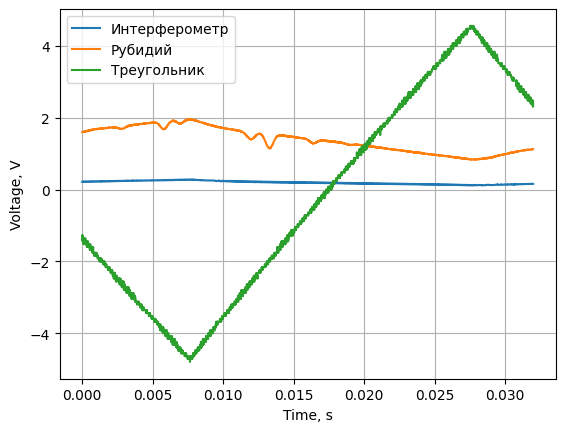

In [13]:

plt.plot(data["Time, s"], data["V_1"], label="Интерферометр")
plt.plot(data["Time, s"], data["V_2"], label="Рубидий")
plt.plot(data["Time, s"], data["V_3"], label="Треугольник")
plt.xlabel("Time, s")
plt.ylabel("Voltage, V")
plt.legend()
plt.grid()



C:\Users\RedBrean\AppData\Local\Temp\ipykernel_22888\1870995849.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["V_poly"] = cut_data["V_2"] / poly_fit(cut_data["Time, s"]) / cut_data["V_2"].max() * cut_data["V_1"].max()


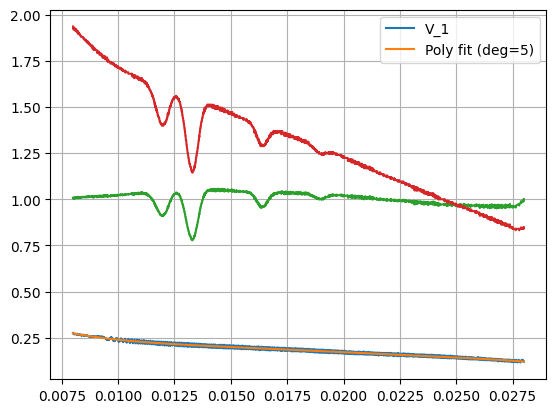

In [14]:
cut_data_power = data[(data["Time, s"] >= 0.008) & (data["Time, s"] <= 0.028)]
cut_data = data[(data["Time, s"] >= 0.008) & (data["Time, s"] <= 0.028)]

# Fit V_1 with a polynomial (e.g., degree 3)
poly_deg = 5
poly_coeffs = np.polyfit(cut_data_power["Time, s"], cut_data_power["V_1"], poly_deg)
poly_fit = np.poly1d(poly_coeffs)

# Divide V_2 by the polynomial fit instead of the linear fit
cut_data["V_poly"] = cut_data["V_2"] / poly_fit(cut_data["Time, s"]) / cut_data["V_2"].max() * cut_data["V_1"].max()

plt.figure()
plt.plot(cut_data["Time, s"], cut_data["V_1"], label="V_1")
plt.plot(cut_data["Time, s"], poly_fit(cut_data["Time, s"]), label=f"Poly fit (deg={poly_deg})")
plt.legend()
plt.plot(cut_data["Time, s"], cut_data["V_poly"])
plt.plot(cut_data["Time, s"], cut_data["V_2"])
plt.grid()


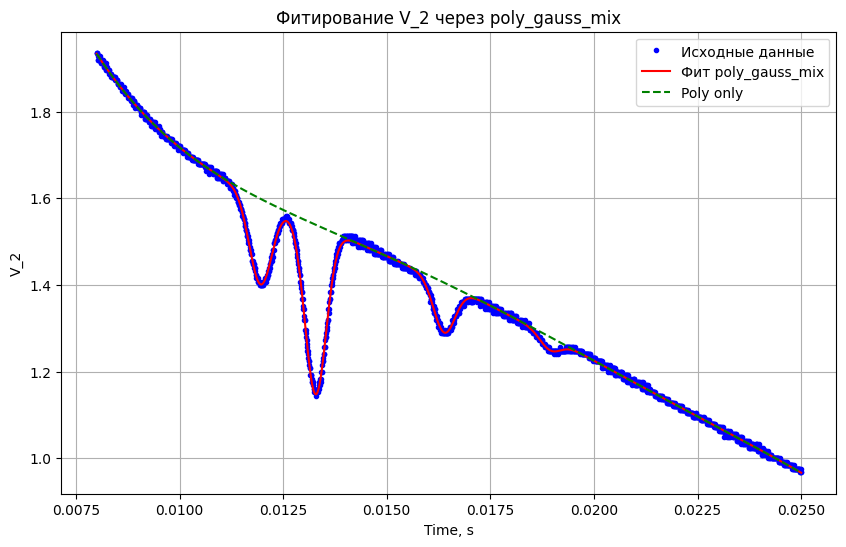

p[0] = -2199288422.2957244
p[1] = 209021357.78378582
p[2] = -7793951.2788507845
p[3] = 141860.70119790564
p[4] = -1302.8363608615684
p[5] = 6.483609243121209
p[6] = 0.12347073875081287
p[7] = 0.011953876836864335
p[8] = 0.00027006459419154756
p[9] = 0.2542590674576073
p[10] = 0.013283713443595536
p[11] = 0.00025553302971804325
p[12] = 0.08187333771845659
p[13] = 0.016387492158381277
p[14] = 0.00026036726305799814
p[15] = 0.024081300495044127
p[16] = 0.018941782784082956
p[17] = 0.0002446426321528879
[-2.19928842e+09  2.09021358e+08 -7.79395128e+06  1.41860701e+05
 -1.30283636e+03  6.48360924e+00] [1.23470739e-01 1.19538768e-02 2.70064594e-04 2.54259067e-01
 1.32837134e-02 2.55533030e-04 8.18733377e-02 1.63874922e-02
 2.60367263e-04 2.40813005e-02 1.89417828e-02 2.44642632e-04]


In [27]:
cut_data_wide = data[(data["Time, s"] >= 0.008) & (data["Time, s"] <= 0.025)]
cut_data = data[(data["Time, s"] >= 0.008) & (data["Time, s"] <= 0.025)]

def poly_gauss_mix(x, *params):
    """
    params: [p0, p1, ..., pn, A1, mu1, sigma1, ..., A4, mu4, sigma4]
    p0...pn — коэффициенты многочлена степени n
    Ai, mui, sigmai — параметры 4 гауссиан
    """
    n = 4  # число гауссиан
    poly_deg = len(params) - n*3
    poly_coeffs = params[:poly_deg]
    gauss_params = params[poly_deg:]
    # Многочлен
    poly = np.polyval(poly_coeffs, x)
    # Сумма 4 гауссиан
    gauss_sum = 0
    for i in range(n):
        A = gauss_params[i*3]
        mu = gauss_params[i*3+1]
        sigma = gauss_params[i*3+2]
        gauss_sum += A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return poly * (1-gauss_sum)



gauss_params = [0.1, 0.011, 0.0004,  # First Gaussian
                0.2, 0.013, 0.0004,
                0.1,0.016,0.0004,
                0.05,0.019,0.0004]  # Second Gaussian

x = cut_data_wide["Time, s"].values
y = cut_data_wide["V_2"].values

# Fit V_2 with a polynomial of degree 3
poly_params = np.polyfit(x, y, 1)
# Update initial_params with the fitted polynomial coefficients
initial_params = list(poly_params) + gauss_params

# Фитирование
popt_1, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)
degree = 5
initial_params = [0]*(degree-1) + list(popt_1) # Добавляем степени многочлена
popt_2, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)
poly_params = popt_2[:degree+1]
gauss_params = popt_2[degree+1:]
# Графики
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Исходные данные')
plt.plot(x, poly_gauss_mix(x, *popt_2), 'r-', label='Фит poly_gauss_mix')
plt.xlabel("Time, s")
plt.ylabel("V_2")
plt.legend()
plt.grid(True)
plt.title("Фитирование V_2 через poly_gauss_mix")
plt.plot(x, np.polyval(poly_params, x), 'g--', label='Poly only')
plt.legend()
plt.show()
for i, coef in enumerate(popt_2):
    print(f"p[{i}] = {coef}")

print(poly_params, gauss_params)

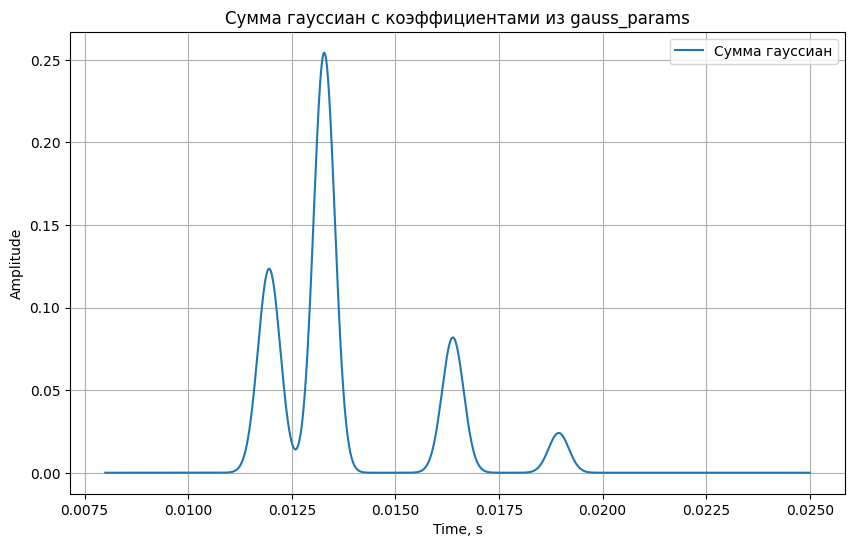

0.48560997247973936 0.29412872573797016


In [16]:
def sum_gaussians(x, gauss_params):
    n = len(gauss_params) // 3
    gauss_sum = np.zeros_like(x)
    for i in range(n):
        A = gauss_params[i*3]
        mu = gauss_params[i*3+1]
        sigma = gauss_params[i*3+2]
        gauss_sum += A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return gauss_sum

gauss_params_tuples = [(gauss_params[i], gauss_params[i+1], gauss_params[i+2]) for i in range(0, len(gauss_params), 3)]

plt.figure(figsize=(10, 6))
plt.plot(x, sum_gaussians(x, gauss_params), label="Сумма гауссиан")
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.title("Сумма гауссиан с коэффициентами из gauss_params")
plt.grid(True)
plt.legend()
plt.show()

print(gauss_params_tuples[0][0]/gauss_params_tuples[1][0], gauss_params_tuples[3][0]/gauss_params_tuples[2][0])

188


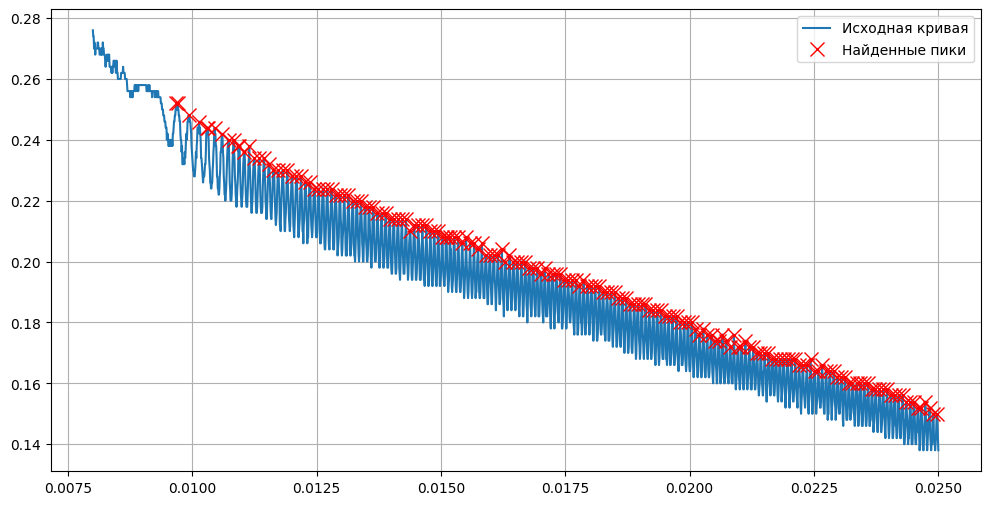

In [17]:
# Допустим, у нас есть массив y с значениями кривой
x=cut_data["Time, s"]
y=cut_data["V_1"]
# Находим пики (локальные максимумы)
peaks, _ = sp.signal.find_peaks(np.array(y),   
    distance=2,          # минимум 50 точек между пиками
    prominence=0.01,       # минимальная "выдающаяся" высота
    width=1 )

# Визуализируем результат
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Исходная кривая')
plt.plot(np.array(x)[peaks], np.array(y)[peaks], "rx", markersize=10, label='Найденные пики')
peaksx = np.array(x)[peaks]
distances = peaksx*0
for i in range(len(peaksx)-1):
    distances[i] = peaksx[i+1]-peaksx[i]
print(len(distances))
plt.legend()
plt.grid(True)
plt.show()